**Repository**: https://github.com/EstebanMqz/SP500-Risk-Optimized-Portfolios-PostCovid-ML

### <font color= 'orange'> **S & P 500 Risk Optimized Portfolios PostCovid ML** <font> 

In [2]:
#Import dependencies
import functions as fn
import data as dt
import visualizations as vs

#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import scipy
import scipy.stats as st
from scipy import optimize
from scipy.optimize import minimize

import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from yahoofinancials import YahooFinancials 
from tabulate import tabulate
import IPython.display as d

import datetime 
import time

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

##### <span style='color:red'> Project Creators:</span> Create requirements.txt file.<br>

In [3]:
docstring = """
# -- --------------------------------------------------------------------------------------------------  -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                              -- # 
# -- script: requirements.txt: txt file to download Python modules for execution                         -- # 
# -- author: EstebanMqz                                                                                  -- # 
# -- license: CC BY 3.0                                                                                  -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt                 -- #                                  
# -- --------------------------------------------------------------------------------------------------  -- # 
\n
"""

fn.get_requirements(docstring)

requirements.txt file created in local path: c:\Users\Esteban\Desktop\Projects\Github\Repos_To-do\Languages\Python\Fin_Sim\Simulation_Course_Exams\SP500-Risk-Optimized-Portfolios-ML\requirements.txt


##### <span style='color:green'> Project Users:</span> Install libraries in requirements.txt file.<br>

In [4]:
dt.library_install("requirements.txt")

Requirements installed.

# -- --------------------------------------------------------------------------------------------------  -- # 
# -- project: S&P500-Risk-Optimized-Portfolios-PostCovid-ML                                              -- # 
# -- script: requirements.txt: txt file to download Python modules for execution                         -- # 
# -- author: EstebanMqz                                                                                  -- # 
# -- license: CC BY 3.0                                                                                  -- # 
# -- repository: SP500-Risk-Optimized-Portfolios-PostCovid-ML/blob/main/requirements.txt                 -- #                                  
# -- --------------------------------------------------------------------------------------------------  -- # 


numpy >= 1.23.5 
pandas >= 1.4.4 
matplotlib >= 3.5.3 
scipy >= 1.7.3 
sklearn >= 1.0.2 
jupyter >= 1.0.0 
yahoofinanicals >= 1.14 
tabulate >= 0.8.9 
IPython >= 8

*Fetching a lot of data from Yahoo Finance by batches is required to avoid host disruptions. Other sources could be used too.*<br>

In [3]:
tickers=fn.SP500_tickers(50)
tickers[0][:5], tickers[-1][-5:]

(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN'], ['ZBH', 'ZION', 'ZTS'])

In [16]:
data = pd.concat([dt.get_historical_price_data(tickers[i][j], 6) for i in range(0, len(tickers)) for j in range(0, len(tickers[i]))], axis=1)

In [18]:
data.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,
2017-05-03,162.043854,48.743839,39.475151,51.116432,109.965675,51.255013,34.894707,134.850006,86.048775,132.375244,...,122.974777,172.568222,117.194092,37.648579,46.482605,61.688683,93.940002,110.681953,34.834156,53.488342
2017-05-04,163.585312,49.456680,40.260685,51.491741,110.440979,51.507210,35.815437,134.610001,87.451859,134.219681,...,130.618866,169.673080,115.769318,37.825409,47.934036,62.348507,94.290001,108.290924,34.911404,56.644333
2017-05-05,163.495132,49.925892,40.305840,51.307919,111.080849,52.215321,35.840771,134.839996,87.619537,134.377319,...,132.325714,171.202072,113.739258,37.934875,48.659733,62.637730,96.559998,108.003632,34.980083,57.221653
2017-05-08,162.880142,49.483749,40.341949,50.710514,110.706100,52.370518,36.288464,135.119995,85.333954,136.221771,...,132.408264,170.975891,111.932678,38.002243,48.566692,62.493114,96.690002,108.346542,35.366371,56.586601
2017-05-09,162.314377,49.483749,40.332912,50.679886,110.669525,52.981621,35.781651,135.600006,85.669304,135.433914,...,130.407822,169.881195,115.448708,37.699104,48.241055,62.149662,98.449997,109.968353,35.134594,57.183159


In [29]:
data.tail()
data.to_csv("sp500.csv")

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
formatted_date,,,,,,,,,,,,,,,,,,,,,
2023-04-25,104.370003,68.265244,109.970001,164.899994,270.700012,86.739998,75.900002,369.589996,211.690002,123.779999,...,239.589996,671.830017,111.629997,71.180000,102.919998,137.809998,284.100006,139.059998,26.730000,173.020004
2023-04-26,102.919998,67.200005,108.750000,161.800003,271.209991,76.809998,77.029999,363.059998,210.830002,122.330002,...,237.770004,659.820007,109.449997,69.680000,100.980003,138.009995,280.420013,139.080002,26.389999,172.940002
2023-04-27,105.330002,68.559998,109.500000,148.869995,275.450012,77.610001,78.010002,371.420013,216.160004,124.900002,...,225.809998,696.359985,110.220001,70.260002,103.830002,139.800003,284.119995,138.350006,26.580000,173.949997
2023-04-28,106.220001,68.290001,110.470001,151.119995,280.290009,77.709999,78.080002,377.559998,220.000000,125.529999,...,231.600006,695.570007,114.279999,69.910004,103.839996,140.580002,288.029999,138.440002,27.860001,175.779999
2023-05-01,105.849998,70.139999,111.110001,153.710007,279.420013,77.430000,77.800003,374.149994,221.119995,125.470001,...,233.240005,695.960022,115.599998,70.169998,104.500000,142.229996,287.450012,138.830002,26.820000,179.559998


Now that we have downloaded our data, we can start analyzing it with $R_{yr}$, $\sigma_{yr}$ and some $Ratios$ as an example: <br>

$R_{Sharpe} = \frac{Returns - {rf}}{\sigma}$ <br>
$R_{Sortino} = \frac{Returns - {rf}}{\sigma_{downside}}$ <br>

,Annualized Return,Volatility,Sharpe Ratio,Sortino Ratio
ENPH,1.518291,0.789591,1.901479,3.293286
TDG,0.451852,0.255364,1.703261,2.788401
DXCM,0.786397,0.501397,1.534707,2.616126
CMG,0.602974,0.364806,1.606536,2.569614
AMD,0.920863,0.585987,1.542632,2.404627
CSGP,0.405487,0.268307,1.448293,2.364980
PAYC,0.688312,0.395736,1.696613,2.363065
FICO,0.500005,0.287623,1.679648,2.311393
KEYS,0.504359,0.319989,1.523362,2.273103
ZTS,0.344071,0.221555,1.476701,2.238899


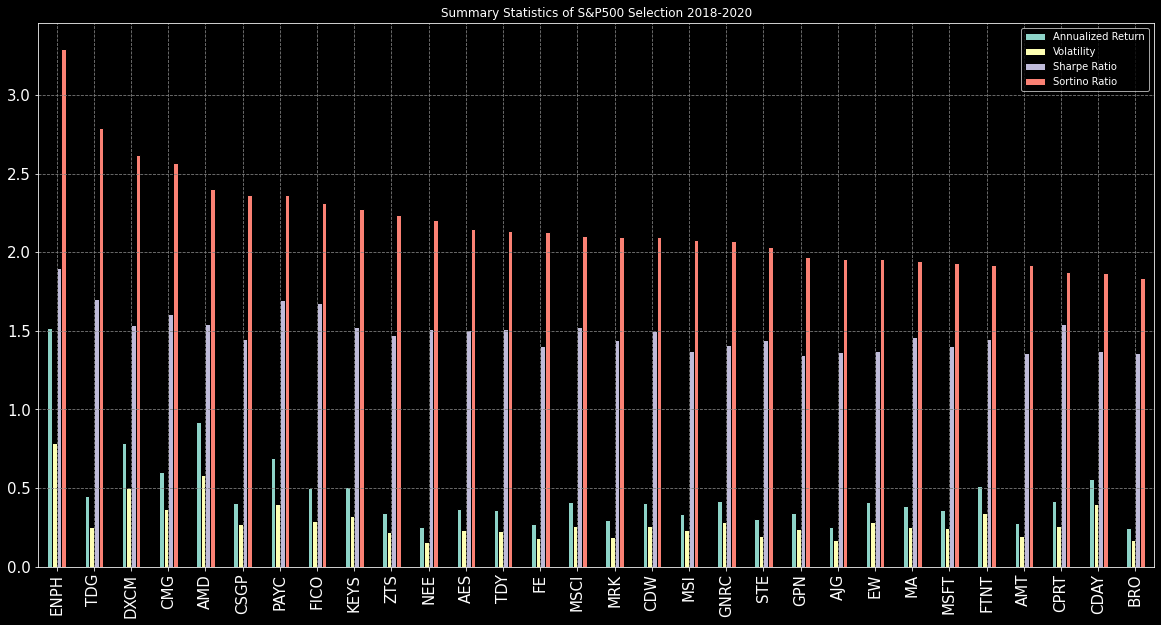

In [4]:
SP = pd.read_csv("Data/sp500.csv", index_col=0)
plt.style.use("dark_background")
summary18_20 = vs.selection_data(SP.loc["2018-01-02":"2020-01-02"], 0.0169, "Summary Statistics of S&P500 Selection 2018-2020")[0]
summary18_20

For $i = 1,2,3,...n$ samples if $x_i$ ~ $N(\mu, \sigma^2)$ then: <br>

in an equally weighted dataset we *would* have got the following params : <br><br>

$$\mu_{{x_{i}}}, \sigma_{i} = \frac{1}{n} \bigg(\sum_{i=1}^{n} \mu_{{x_{i}}}, \sqrt{\sum_{i=1}^{n}\left(\mu_{{x_{i}}}-\bar{\mu}\right)^{2}}\bigg)$$
<br>

In a weighted dataset with unknown distributions and weights where:<br>

$$\sum_{n}^{} w=1$$

For *i.i.d* randomly generated variables $\forall x_i \in X_{i}\sim U(0,1)$<br>
with the property $E(X+Y) = E(X) + E(Y)$, the best estimator for $\mu_{p}$ is easily obtained: <br>


$$\mu_{p} = \frac{1}{n} \sum_{i=1}^{n} w_{i} \sum_{i=1}^{n} \mu_{{x_{i}}} = \sum_{i=1}^n (w_i) \mu_{{x_{i}}}$$ 

To calculate $\sigma_p$ we need the variance of the sum of the random variables: <br>

$$\sigma_{P} = \sqrt{\sum_{i=1}^{n} w_{i}^{2} \sigma_{i}^{2} + \sum_{i=1}^{n} \sum_{j=1, j \neq i}^{n} w_{i} w_{j} \sigma_{i} \sigma_{j} \rho_{i j}}$$

where $\rho_{i j} = \frac{Cov(X_i, X_j)}{\sigma_{i} \sigma_{j}}$ is the correlation coefficient.

So it can be reduced to $\sigma_{P} = \sqrt{w^{T} \times COV_{1,n} \times w}$ and solved as a product of matrices $\times$ vectors: <br><br><br>

$$\sigma_{P} = \sqrt{\left[\begin{array}{cccc}w_{1} & w_{2} & \cdots & w_{n}\end{array}\right] \cdot \left[\begin{array}{cccc}1 & \rho_{1,2} & \cdots & \rho_{1,n} \\ \rho_{2,1} & 1 & \cdots & \rho_{2,n} \\ \vdots & \vdots & \ddots & \vdots \\ p_{n,1} & \cdots & \cdots & 1\end{array}\right] \cdot \left[\begin{array}{cccc}w_{1} \\ w_{2} \\ \vdots \\ w_{n}\end{array}\right]}$$

Therefore, we can verify that the following are the optimized portfolios with respect to:
+ $Sharpe-R_{max}$ $\bigg(E[\frac{r_p}{\sigma}]\bigg)$
+ $Port._{min_{Var}}$
+ $Sortino-R_{max}\bigg(E[\frac{r_p}{\sigma_{r<0}}]\bigg)$ 

on given periods:

In [5]:
df, plt = vs.Optimizer(SP, 0.0169)

NameError: name 'summary18_20' is not defined

In [7]:
df

,Assets
0,"('EMV:', 'E(r)=', 0.48, 'σ=', 0.13)"
1,"('Port. min. var.', 'E(r)=', 0.12, 'σ=', 0.08)"
2,Capital Allocation Line
3,"('W=', 0.08, 'r=', 1.52, 's=', 0.79)"
4,"('W=', 0.0, 'r=', 0.45, 's=', 0.26)"
5,"('W=', 0.04, 'r=', 0.79, 's=', 0.5)"
6,"('W=', 0.1, 'r=', 0.6, 's=', 0.36)"
7,"('W=', 0.03, 'r=', 0.92, 's=', 0.59)"
8,"('W=', 0.01, 'r=', 0.5, 's=', 0.32)"
9,"('W=', 0.13, 'r=', 0.25, 's=', 0.16)"
